Import libraries

In [44]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, 
    confusion_matrix, top_k_accuracy_score
)
from sklearn.model_selection import train_test_split

torch.manual_seed(42)
np.random.seed(42)

In [45]:
folder_path = "/home/zebborjesson/Documents/school/tra300_digitalization_in_sports/tra300-ski-technique-classification/data_sync/outputs"

# ==== CONFIG ====
TEST_FILE = "BIA24-3_NR_merged_with_gear.csv"

# Define Feature Groups
feature_columns_pole_data = [
    'speed_kmph', 'power_w', 'frequency_ppm', 'thrust_left_ms', 'thrust_right_ms', 
    'impulse_left_ns', 'impulse_right_ns', 'force_meanl_n', 'force_meanr_n', 'f_tot_mean_n'
]
feature_columns_gnss = [
    'ns1:AltitudeMeters', 'ns2:Speed', 'ns2:RunCadence', 'ns2:Watts'
]
new_ratio_cols = ["force_ratio", "thrust_ratio", "impulse_ratio"]

input_cols = feature_columns_pole_data + feature_columns_gnss + new_ratio_cols
output_cols = ["Gear"]
label_col = output_cols[0]

TRANSITION_SAMPLES_TO_REMOVE = 3

# ==== HELPER FUNCTIONS ====

def normalize_label(val: object) -> str:
    """Standardizes labels like '2.0H' -> '2.0'"""
    s = str(val).strip()
    m = re.search(r'^-?\d+(?:\.\d+)?', s)
    if m:
        return f"{float(m.group(0)):.1f}"
    return s

def make_sure_numeric(df, columns):
    """Coerces specified columns to numeric, turning errors into NaNs."""
    for col in columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def add_ratios(df):
    """Adds force, thrust, and impulse ratios."""
    df = df.copy()
    eps = 1e-6
    if 'force_meanl_n' in df.columns and 'force_meanr_n' in df.columns:
        df["force_ratio"] = df["force_meanl_n"] / (df["force_meanl_n"] + df["force_meanr_n"] + eps)
    if 'thrust_left_ms' in df.columns and 'thrust_right_ms' in df.columns:
        df["thrust_ratio"] = df["thrust_left_ms"] / (df["thrust_left_ms"] + df["thrust_right_ms"] + eps)
    if 'impulse_left_ns' in df.columns and 'impulse_right_ns' in df.columns:
        df["impulse_ratio"] = df["impulse_left_ns"] / (df["impulse_left_ns"] + df["impulse_right_ns"] + eps)
    return df

def filter_unstable_gears(df: pd.DataFrame, label_col: str, window_size: int) -> pd.DataFrame:
    """Removes samples in a window around where the label (gear) changes."""
    if df.empty: return df
    
    # Identify changes
    gear_changes = df[label_col].ne(df[label_col].shift(1))
    change_points = df[gear_changes].index.tolist()
    
    remove_indices = set()
    for idx in change_points:
        # Remove BEFORE switch
        for i in range(idx - window_size, idx):
            remove_indices.add(i)
        # Remove AFTER switch
        for i in range(idx, idx + window_size):
            remove_indices.add(i)
            
    return df.drop(index=list(remove_indices), errors='ignore')

# ==== LOAD DATA ====
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv') and "NR" in f]
dataframes = {}

print(f"Loading {len(csv_files)} files...")
cols_to_numeric = feature_columns_pole_data + feature_columns_gnss

for file in csv_files:
    full_path = os.path.join(folder_path, file)
    df = pd.read_csv(full_path)
    
    # 1. Feature Engineering
    df = make_sure_numeric(df, cols_to_numeric)
    df = add_ratios(df)
    
    # 2. Normalize Labels
    df[label_col] = df[label_col].apply(normalize_label)
    
    # 3. Filter Transitions (Done per file to avoid concatenation bugs)
    df = filter_unstable_gears(df, label_col, TRANSITION_SAMPLES_TO_REMOVE)
    
    dataframes[file] = df

print("\nUsing inputs:", input_cols)
print("Using output:", output_cols)
print("Test file:", TEST_FILE)

# ==== SPLIT STRATEGY (CRITICAL FIX) ====
# Split by FILES, not by random rows, to prevent data leakage.
all_keys = sorted([k for k in dataframes.keys() if k != TEST_FILE])
test_key = TEST_FILE

train_keys, val_keys = train_test_split(all_keys, test_size=0.2, random_state=42)

print(f"Train files: {len(train_keys)}")
print(f"Val files:   {len(val_keys)}")

# Concatenate
train_df = pd.concat([dataframes[k] for k in train_keys], ignore_index=True)
val_df = pd.concat([dataframes[k] for k in val_keys], ignore_index=True)
test_df = dataframes[test_key].copy()

# Drop NaNs
needed_cols = list(set(input_cols + output_cols))
train_df = train_df.dropna(subset=needed_cols).reset_index(drop=True)
val_df = val_df.dropna(subset=needed_cols).reset_index(drop=True)
test_df = test_df.dropna(subset=needed_cols).reset_index(drop=True)

Loading 12 files...

Using inputs: ['speed_kmph', 'power_w', 'frequency_ppm', 'thrust_left_ms', 'thrust_right_ms', 'impulse_left_ns', 'impulse_right_ns', 'force_meanl_n', 'force_meanr_n', 'f_tot_mean_n', 'ns1:AltitudeMeters', 'ns2:Speed', 'ns2:RunCadence', 'ns2:Watts', 'force_ratio', 'thrust_ratio', 'impulse_ratio']
Using output: ['Gear']
Test file: BIA24-3_NR_merged_with_gear.csv
Train files: 8
Val files:   3


In [46]:
# ---- Encode labels using ALL labels (train + val + test) ----
label_encoder = LabelEncoder()
all_labels = pd.concat([train_df[label_col], val_df[label_col], test_df[label_col]], ignore_index=True)
label_encoder.fit(all_labels)

y_train = label_encoder.transform(train_df[label_col])
y_val = label_encoder.transform(val_df[label_col])
y_test = label_encoder.transform(test_df[label_col])
num_classes = len(label_encoder.classes_)

# Warn if any class exists only in test
train_classes = set(np.unique(y_train))
val_classes = set(np.unique(y_val))
test_classes = set(np.unique(y_test))

only_in_test = sorted(list(test_classes - train_classes - val_classes))
if only_in_test:
    names_only_in_test = [label_encoder.classes_[i] for i in only_in_test]
    print("⚠️ These classes exist only in TEST:", names_only_in_test)

# ---- Prepare inputs ----
X_train = train_df[input_cols].values.astype(np.float32)
X_val = val_df[input_cols].values.astype(np.float32)
X_test = test_df[input_cols].values.astype(np.float32)

# Fit Scaler ONLY on Train (prevents leakage)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# ---- Convert to PyTorch tensors ----
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)

y_train_t = torch.tensor(y_train, dtype=torch.long)
y_val_t = torch.tensor(y_val, dtype=torch.long)
y_test_t = torch.tensor(y_test, dtype=torch.long)

print(f"Train size: {len(X_train_t)} | Val size: {len(X_val_t)} | Test size: {len(X_test_t)}")
print(f"Classes: {label_encoder.classes_}")

Train size: 7122 | Val size: 2708 | Test size: 974
Classes: ['0.0' '2.0' '3.0' '4.0']


In [47]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hidden, dropout=0.2):
        super().__init__()
        layers = []
        prev = in_dim
        for h in hidden:
            layers += [nn.Linear(prev, h), nn.ReLU(), nn.Dropout(dropout)]
            prev = h
        layers += [nn.Linear(prev, out_dim)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# Compute class weights (Weighted Loss)
class_counts = torch.bincount(y_train_t)
# 1.0 / count (clamped to avoid division by zero if a class is missing in train but present in encoder)
class_weights = 1.0 / class_counts.float().clamp_min(1.0)
# Normalize so they sum to num_classes
class_weights = class_weights * (len(class_counts) / class_weights.sum())

input_dim = X_train_t.shape[1]
output_dim = num_classes

model = MLP(input_dim, output_dim, hidden=(128, 128, 128), dropout=0.3)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

print(model)
print("Class weights:", class_weights.tolist())

MLP(
  (net): Sequential(
    (0): Linear(in_features=17, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=128, out_features=4, bias=True)
  )
)
Class weights: [0.7920357584953308, 1.0182271003723145, 0.27036115527153015, 1.9193757772445679]


In [48]:
# === BALANCE TRAINING SET ===
# Make all classes in train_df equally represented (undersampling or oversampling)

print("Training class counts BEFORE balancing:")
print(train_df[label_col].value_counts())

# Determine target count per class
counts_before = train_df[label_col].value_counts()
min_count = counts_before.max()  # You can change to max() to oversample instead

balanced_parts = []

#for cls, group in train_df.groupby(label_col):
#    if len(group) >= min_count:
#        # Undersample large classes
#        balanced_parts.append(group.sample(min_count, random_state=42))
#    else:
#        # Oversample small classes
#        balanced_parts.append(group.sample(min_count, replace=True, random_state=42))

# Combine and shuffle
#train_df = pd.concat(balanced_parts).sample(frac=1, random_state=42).reset_index(drop=True)

print("\nTraining class counts AFTER balancing:")
print(train_df[label_col].value_counts())
print(f"\nNew balanced TRAIN size: {len(train_df)}")


Training class counts BEFORE balancing:
Gear
3.0    4075
0.0    1391
2.0    1082
4.0     574
Name: count, dtype: int64

Training class counts AFTER balancing:
Gear
3.0    4075
0.0    1391
2.0    1082
4.0     574
Name: count, dtype: int64

New balanced TRAIN size: 7122


In [ ]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hidden, dropout=0.2):
        super().__init__()
        layers = []
        prev = in_dim
        for h in hidden:
            layers += [nn.Linear(prev, h), nn.ReLU(), nn.Dropout(dropout)]
            prev = h
        layers += [nn.Linear(prev, out_dim)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# Compute class weights to help with imbalance
class_counts = torch.bincount(y_train_t)
class_weights = 1.0 / class_counts.float().clamp_min(1.0)
class_weights = class_weights * (len(class_counts) / class_weights.sum())

model = MLP(input_dim, output_dim, hidden=(64, 32), dropout=0.2)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-3)

print(model)
print("Class counts:", class_counts.tolist())
print("Class weights:", class_weights.tolist())


MLP(
  (net): Sequential(
    (0): Linear(in_features=17, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=4, bias=True)
  )
)
Class counts: [1391, 1082, 4075, 574]
Class weights: [0.7920357584953308, 1.0182271003723145, 0.27036115527153015, 1.9193757772445679]


In [50]:
# Compute class weights to help with imbalance (This is the one that counts)
class_counts = torch.bincount(y_train_t)
class_weights = 1.0 / class_counts.float().clamp_min(1.0)
class_weights = class_weights * (len(class_counts) / class_weights.sum())

model = MLP(input_dim, output_dim, hidden=(128, 128, 128), dropout=0.2)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

print(model)
print("Training Class counts:", class_counts.tolist())
print("Training Class weights:", class_weights.tolist())

# --- Training Configuration ---
EPOCHS = 200
BATCH_SIZE = 256
PRINT_EVERY = 1

def batches(X, y, batch_size):
    n = len(X)
    idx = np.arange(n)
    np.random.shuffle(idx)
    for start in range(0, n, batch_size):
        end = start + batch_size
        sel = idx[start:end]
        yield X[sel], y[sel]

# --- Variables for tracking history ---
# (Removed best_val_loss and best_model_state)
history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

print("Starting training...")

for epoch in range(1, EPOCHS + 1):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    for Xb, yb in batches(X_train_t, y_train_t, BATCH_SIZE):
        optimizer.zero_grad()
        out = model(Xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    avg_train_loss = running_loss / max(1, (len(X_train_t) // BATCH_SIZE))
    history['train_loss'].append(avg_train_loss)

    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        val_out = model(X_val_t)
        val_loss = criterion(val_out, y_val_t).item() # Use .item() to get Python number
        
        val_pred = val_out.argmax(dim=1)
        val_correct = (val_pred == y_val_t).sum().item()
        
    val_accuracy = val_correct / len(y_val_t)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_accuracy)

    # --- Print Epoch Stats ---
    if epoch % PRINT_EVERY == 0:
        print(f"Epoch {epoch:03d} | Train loss: {avg_train_loss:.4f} | Val loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f}")

    # --- (Removed "Save Best Model" block) ---

print("Training finished.")

# --- (Removed "Load Best Model" block) ---
print("\nUsing model state from final epoch for evaluation.")

MLP(
  (net): Sequential(
    (0): Linear(in_features=17, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=128, out_features=4, bias=True)
  )
)
Training Class counts: [1391, 1082, 4075, 574]
Training Class weights: [0.7920357584953308, 1.0182271003723145, 0.27036115527153015, 1.9193757772445679]
Starting training...
Epoch 001 | Train loss: 1.2389 | Val loss: 1.0330 | Val Acc: 0.4793
Epoch 002 | Train loss: 0.7519 | Val loss: 0.8784 | Val Acc: 0.6998
Epoch 003 | Train loss: 0.5624 | Val loss: 0.9221 | Val Acc: 0.7382
Epoch 004 | Train loss: 0.4855 | Val loss: 0.9269 | Val Acc: 0.7493
Epoch 005 | Train loss: 0.4574 | Val loss: 0.9247 | Val Acc: 0.7563
Epoch 006 | Train loss: 0.4265 | Val loss: 0

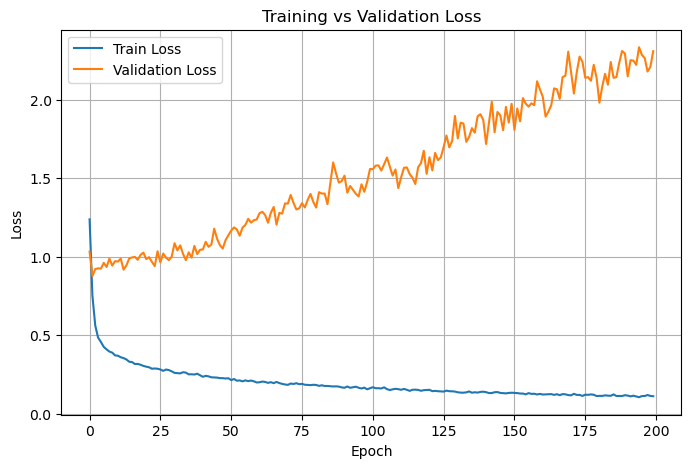

Test Accuracy: 0.5770

              precision    recall  f1-score   support

         0.0       0.14      1.00      0.25        62
         2.0       0.98      0.96      0.97       181
         3.0       0.95      0.48      0.63       677
         4.0       0.17      0.09      0.12        54

    accuracy                           0.58       974
   macro avg       0.56      0.63      0.49       974
weighted avg       0.86      0.58      0.64       974



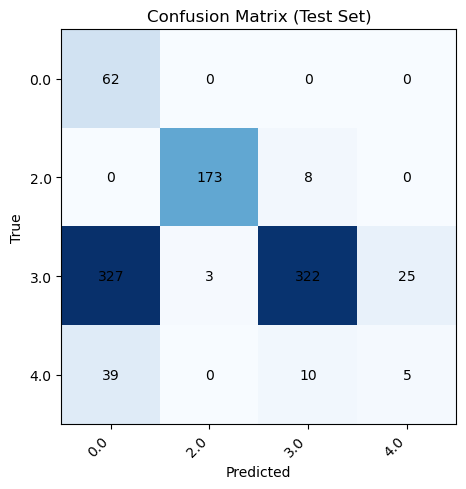

In [51]:
# === Plot Training vs Validation Loss ===
plt.figure(figsize=(8, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# === Evaluation on Test Set ===
model.eval()
with torch.no_grad():
    logits = model(X_test_t)
    
probs = torch.softmax(logits, dim=1).cpu().numpy()
pred_labels = probs.argmax(axis=1)
y_true = y_test_t.cpu().numpy()

acc = accuracy_score(y_true, pred_labels)
print(f"Test Accuracy: {acc:.4f}\n")

target_names = list(label_encoder.classes_)
print(classification_report(y_true, pred_labels, target_names=target_names))

# Confusion matrix
cm = confusion_matrix(y_true, pred_labels)
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=np.arange(len(target_names)), labels=target_names, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(target_names)), labels=target_names)

for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha='center', va='center', color='black')

plt.tight_layout()
plt.show()